<a href="https://colab.research.google.com/github/jhtwiz/hanghaeAI/blob/main/1%E1%84%8C%E1%85%AE%E1%84%8E%E1%85%A1_%E1%84%89%E1%85%B5%E1%86%B7%E1%84%92%E1%85%AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:03<00:00, 43388804.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print(trainset.classes)
print(len(trainset.classes))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


50000
torch.Size([3, 32, 32]) 9


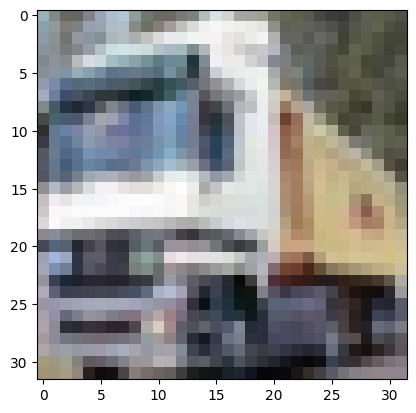

In [4]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[1][1])
sample = np.transpose(trainset[1][0], (1,2,0))
plt.imshow(sample)
# plt.imshow(trainset[0][0][0], cmap='gray')

In [5]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [7]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

In [8]:
from torch.optim import SGD, Adam

lr = 0.001

model_opt_sgd = Model(3 * 32 * 32, 1024)
model_opt_adam = Model(3 * 32 * 32, 1024)

model_opt_sgd = model_opt_sgd.to('cuda')
model_opt_adam = model_opt_adam.to('cuda')

optimizer_sgd = SGD(model_opt_sgd.parameters(), lr=lr)
optimizer_adam = Adam(model_opt_adam.parameters(), lr=lr)

In [9]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [10]:
def train(model, optimizer, trainloader, testloader=None):
    n_epochs = 50
    train_accs = []
    test_accs = []
    for epoch in range(n_epochs):
      total_loss = 0.

      model.train()
      for data in trainloader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        CEL = torch.nn.CrossEntropyLoss()
        loss = CEL(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      with torch.no_grad():
        model.eval()
        train_accs.append(accuracy(model, trainloader))
        if testloader: test_accs.append(accuracy(model, testloader))

      print(f"Epoch {epoch:3d} | Loss: {total_loss}")

    if testloader:
        return train_accs, test_accs
    else:
        return train_accs

In [11]:
adam_train = train(model_opt_adam, optimizer_adam, trainloader)
sgd_train = train(model_opt_sgd, optimizer_sgd, trainloader)

Epoch   0 | Loss: 365.68675088882446
Epoch   1 | Loss: 324.03324949741364
Epoch   2 | Loss: 305.1731685400009
Epoch   3 | Loss: 292.88848769664764
Epoch   4 | Loss: 284.189369559288
Epoch   5 | Loss: 275.98715806007385
Epoch   6 | Loss: 269.3522803783417
Epoch   7 | Loss: 262.6091243028641
Epoch   8 | Loss: 257.29412829875946
Epoch   9 | Loss: 251.85313034057617
Epoch  10 | Loss: 245.61378115415573
Epoch  11 | Loss: 239.3666135072708
Epoch  12 | Loss: 233.0883024930954
Epoch  13 | Loss: 228.0819262266159
Epoch  14 | Loss: 221.51148635149002
Epoch  15 | Loss: 218.14341139793396
Epoch  16 | Loss: 213.07018899917603
Epoch  17 | Loss: 206.10817432403564
Epoch  18 | Loss: 201.92855721712112
Epoch  19 | Loss: 196.47109007835388
Epoch  20 | Loss: 191.2915381193161
Epoch  21 | Loss: 185.50894170999527
Epoch  22 | Loss: 179.93854302167892
Epoch  23 | Loss: 174.50552207231522
Epoch  24 | Loss: 168.48000746965408
Epoch  25 | Loss: 162.16962671279907
Epoch  26 | Loss: 157.90007257461548
Epoch  27 

In [12]:
from matplotlib import pyplot as plt

def showPlot(*results):
    for result in results:
        data = result['data']
        label = result['label']
        x = np.arange(len(data))
        plt.plot(x, data, label=label)
    plt.legend()
    plt.show()

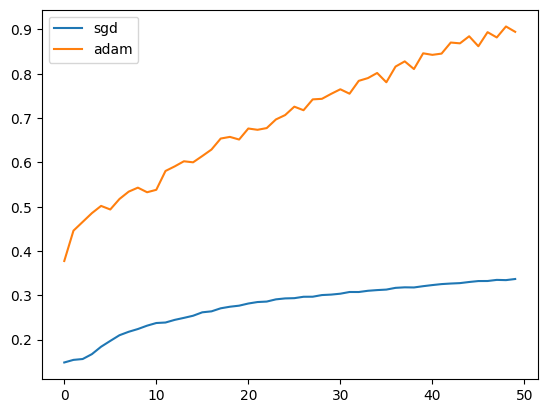

In [13]:
showPlot({'label': 'sgd', 'data': sgd_train}, {'label': 'adam', 'data': adam_train})

In [14]:
class SigmoidModel(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.act = nn.Sigmoid()


    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)

        return x

In [15]:
lr = 0.001

sigModel = SigmoidModel(3 * 32 * 32, 1024)
leakyReLUModel = Model(3 * 32 * 32, 1024)

sigModel = sigModel.to('cuda')
leakyReLUModel = leakyReLUModel.to('cuda')

optim_for_sig = Adam(sigModel.parameters(), lr=lr)
optim_for_leaky = Adam(leakyReLUModel.parameters(), lr=lr)

In [16]:
sig_train = train(sigModel, optim_for_sig, trainloader)
leaky_train = train(leakyReLUModel, optim_for_leaky, trainloader)

Epoch   0 | Loss: 385.80038142204285
Epoch   1 | Loss: 337.88442730903625
Epoch   2 | Loss: 318.2903734445572
Epoch   3 | Loss: 306.95507180690765
Epoch   4 | Loss: 298.61976194381714
Epoch   5 | Loss: 292.85435795783997
Epoch   6 | Loss: 286.03719437122345
Epoch   7 | Loss: 279.9244405031204
Epoch   8 | Loss: 275.229075551033
Epoch   9 | Loss: 269.6192874908447
Epoch  10 | Loss: 266.14175832271576
Epoch  11 | Loss: 261.2508233785629
Epoch  12 | Loss: 258.9817034006119
Epoch  13 | Loss: 253.00425970554352
Epoch  14 | Loss: 250.94309377670288
Epoch  15 | Loss: 245.9550061225891
Epoch  16 | Loss: 241.95963609218597
Epoch  17 | Loss: 238.74486649036407
Epoch  18 | Loss: 234.68365514278412
Epoch  19 | Loss: 231.10901701450348
Epoch  20 | Loss: 228.884395301342
Epoch  21 | Loss: 224.20308125019073
Epoch  22 | Loss: 222.22210627794266
Epoch  23 | Loss: 216.6136656999588
Epoch  24 | Loss: 213.9184798002243
Epoch  25 | Loss: 211.40539771318436
Epoch  26 | Loss: 208.12269818782806
Epoch  27 | L

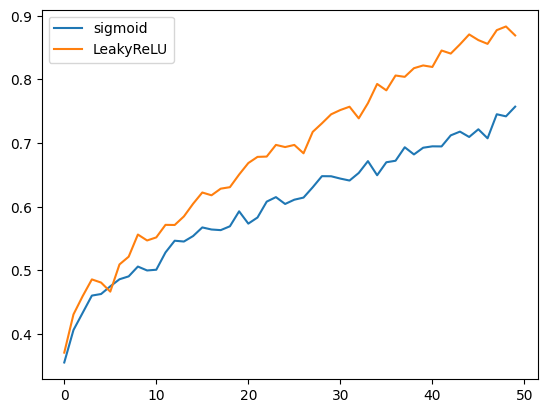

In [17]:
showPlot({'label': 'sigmoid', 'data': sig_train}, {'label': 'LeakyReLU', 'data': leaky_train})

In [18]:
class DropoutModel(nn.Module):

    def __init__(self, input_dim, n_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.dropout(x)
        x = self.act(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)

        return x

In [19]:
dropoutModel = DropoutModel(3 * 32 * 32, 1024)
dropoutModel = dropoutModel.to('cuda')

optim_with_drop = Adam(dropoutModel.parameters(), lr=lr)

In [20]:
train, test = train(dropoutModel, optim_with_drop, trainloader, testloader)

Epoch   0 | Loss: 369.85037076473236
Epoch   1 | Loss: 329.9227223396301
Epoch   2 | Loss: 315.2809833288193
Epoch   3 | Loss: 304.3843047618866
Epoch   4 | Loss: 295.99493062496185
Epoch   5 | Loss: 289.49532210826874
Epoch   6 | Loss: 284.30508756637573
Epoch   7 | Loss: 280.0203763246536
Epoch   8 | Loss: 274.8758739233017
Epoch   9 | Loss: 269.53805208206177
Epoch  10 | Loss: 264.4515423774719
Epoch  11 | Loss: 261.6382894515991
Epoch  12 | Loss: 259.0565047264099
Epoch  13 | Loss: 254.6593325138092
Epoch  14 | Loss: 251.2367033958435
Epoch  15 | Loss: 247.06161737442017
Epoch  16 | Loss: 243.54963397979736
Epoch  17 | Loss: 241.23276388645172
Epoch  18 | Loss: 236.55697882175446
Epoch  19 | Loss: 233.65653264522552
Epoch  20 | Loss: 230.52843594551086
Epoch  21 | Loss: 227.42450147867203
Epoch  22 | Loss: 224.75022095441818
Epoch  23 | Loss: 222.77551263570786
Epoch  24 | Loss: 219.20839536190033
Epoch  25 | Loss: 216.81962651014328
Epoch  26 | Loss: 214.36080527305603
Epoch  27 |

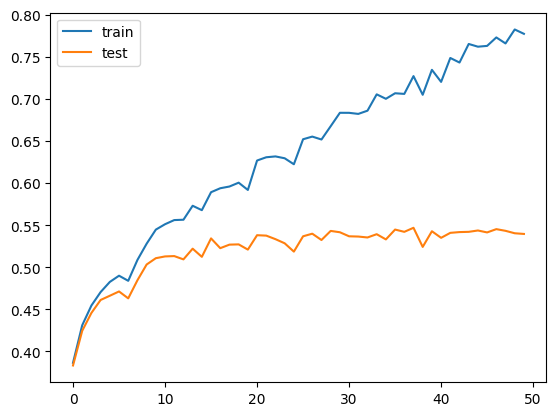

In [21]:
showPlot({'label': 'train', 'data': train}, {'label': 'test', 'data': test})